## Predicting 2023 MLB Season: 04 - Analyzing Odds Data

- In this notebook, I explore the odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [9]:
df=pd.read_csv('./hidden_data/mlb_game_and_odds.csv')

C:\Users\Dylan McGee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (15,85,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Checks / Exploration

In [10]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22801 entries, 0 to 22800
Data columns (total 215 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    date                    22801 non-null  int64  
 1    dblheader_code          22801 non-null  int64  
 2    day_of_week             22801 non-null  object 
 3    team_v                  22801 non-null  object 
 4    league_v                22801 non-null  object 
 5    game_no_v               22801 non-null  int64  
 6    team_h                  22801 non-null  object 
 7    league_h                22801 non-null  object 
 8    game_no_h               22801 non-null  int64  
 9    runs_v                  22801 non-null  int64  
 10   runs_h                  22801 non-null  int64  
 11   outs_total              22801 non-null  int64  
 12   day_night               22801 non-null  object 
 13   completion_info         26 non-null     object 
 14   forfeit_info        

In [11]:
# Do any games not have any odds data associated with them?
pd.crosstab(df.implied_prob_h>0, df.season_x)

season_x,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
implied_prob_h,,,,,,,,,,
True,2483,2484,2452,2485,2499,2492,957,2541,2134,2274


In [12]:
df.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season_x,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OPS_162_h,OPS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,SO_perc_162_h,SO_perc_162_v,BB_perc_162_h,BB_perc_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OPS_30_h,OPS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,SO_perc_30_h,SO_perc_30_v,BB_perc_30_h,BB_perc_30_v,away_point_spread,away_point_spread_line,away_money_line,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_result
7837,20170504,0,Thu,CHA,AL,27,KCA,AL,27,8,3,54,D,NaN,NaN,NaN,KAN06,36525.0,180,210200210,000000210,36,11,2,0,2,8,0,1,2,3,0,8,0,1,1,0,7,4,2,2,0,0,27,8,1,0,1,0,31,5,3,0,0,2,0,1,1,2,0,8,0,0,1,0,5,4,6,6,0,1,27,12,1,1,1,0,millb901,Bill Miller,danlk901,Kerwin Danley,ticht901,Todd Tichenor,hamaa901,Adam Hamari,NaN,(none),NaN,(none),rentr001,Rich Renteria,yoste001,Ned Yost,holld003,Derek Holland,kenni001,Ian Kennedy,NaN,(none),abrej003,Jose Abreu,holld003,Derek Holland,kenni001,Ian Kennedy,salat001,Tyler Saladino,6,cabrm002,Melky Cabrera,7,abrej003,Jose Abreu,3,garca003,Avisail Garcia,9,garcl004,Leury Garcia,8,aschc001,Cody Asche,10,davim005,Matt Davidson,5,sotog001,Geovany Soto,2,sancc001,Yolmer Sanchez,4,merrw001,Whit Merrifield,4,mousm001,Mike Moustakas,5,cainl001,Lorenzo Cain,8,hosme001,Eric Hosmer,3,peres002,Salvador Perez,2,gorda001,Alex Gordon,7,bonij002,Jorge Bonifacio,9,escoa003,Alcides Escobar,6,cuthc001,Cheslor Cuthbert,10,NaN,Y,2017,-5,0,11,201705040,0.255146,0.255449,0.303327,0.310247,0.394005,0.407494,0.697332,0.717741,113.0,76.0,33.0,38.0,94.0,97.0,0.224088,0.236714,0.069159,0.079445,0.217391,0.231768,0.269811,0.286642,0.341759,0.371628,0.611571,0.658270,15.0,10.0,6.0,9.0,13.0,19.0,0.237614,0.249750,0.071790,0.076923,1.5,-157.0,133.0,-1.5,136.0,-148.0,7.5,-110.0,-110.0,0.596774,0.429185,0.583795,O
13262,20190531,0,Fri,TOR,AL,57,COL,NL,56,6,13,51,N,NaN,NaN,NaN,DEN02,32990.0,190,020000040,42401020x,34,11,2,0,2,6,0,2,0,5,0,9,0,0,2,0,8,4,13,13,2,0,24,11,0,0,1,0,40,17,7,0,2,13,0,0,0,5,0,7,0,0,1,0,8,4,6,6,1,0,27,14,0,0,2,0,woodt901,Tom Woodring,onorb901,Brian O'Nora,hoyej901,James Hoye,rippm901,Mark Ripperger,NaN,(none),NaN,(none),montc001,Charlie Mon

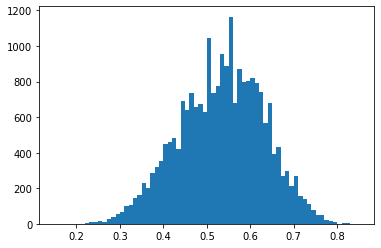

In [15]:
# How confident was the book the home team would win?
plt.hist(df.implied_prob_h_mid, bins=np.linspace(.15,.85,71));

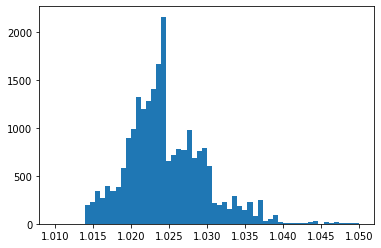

In [17]:
# How much of an edge are the books taking per game?
plt.hist(df.implied_prob_h + df.implied_prob_v, bins=np.linspace(1.01,1.05,61));

looks like on average, vegas takes a 2% - 3% edge on the average MLB game

## Begin Modeling

In [20]:
df = df[df.run_diff!=0] 
df_train = df[(df.season_x>=2000) & (df.season_x<=2020)]
df_valid = df[(df.season_x>=2021) & (df.season_x<=2022)]
df_test = df[df.season_x>=2023]

In [21]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'OPS_162_h','OPS_162_v',
            'SO_perc_162_h','SO_perc_162_v',
            'BB_perc_162_h','BB_perc_162_v'
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [22]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [23]:
X_train.shape, X_valid.shape, X_test.shape, 

((15851, 10), (4675, 10), (2274, 10))

In [24]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 8465, number of negative: 7386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 15851, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534036 -> initscore=0.136354
[LightGBM] [Info] Start training from score 0.136354
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688544
[20]	valid_0's binary_logloss: 0.687161
[30]	valid_0's binary_logloss: 0.686207
[40]	valid_0's binary_logloss: 0.685297
[50]	valid_0's binary_logloss: 0.684682
[60]	valid_0's binary_logloss: 0.68417
[70]	valid_0's binary_logloss: 0.683774
[80]	valid_0's binary_logloss: 0.683588
[90]	valid_0's binary_logloss: 0.683565
[100]	valid_0's binary_log

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [25]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [26]:
hv_mean = y_train.mean()

In [27]:
# Compare our log loss to naive model log loss
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.6856714594909721, 0.6931908659505537)

In [28]:
# Calculate log loss of Vegas
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6765219544154276

las vegas predictions perform better than our model based on their log loss

In [31]:
# How well/bad is our model performing from the naive model vs. vegas?
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.4511036274765816

We are about 45% of the way to replicating a model that performs as well as Vegas 

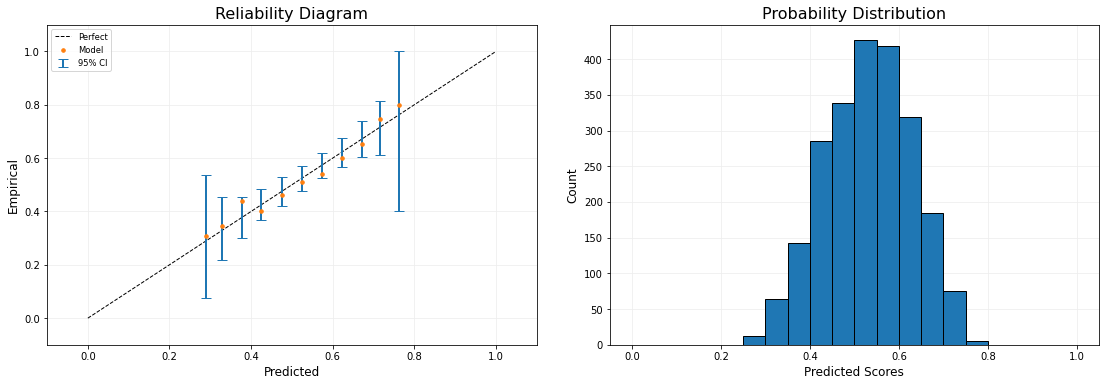

In [30]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

## Analyze discrepancies

In [32]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

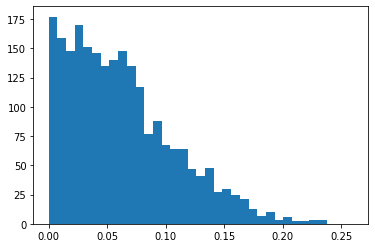

In [35]:
# How often is our model vastly different from Vegas?
plt.hist(test_disc, np.linspace(0,.26,36));

In [37]:
# filter just by gfames where our model was > 20% off from Vegas prediction
df_test[test_disc>.2]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season_x,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OPS_162_h,OPS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,SO_perc_162_h,SO_perc_162_v,BB_perc_162_h,BB_perc_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OPS_30_h,OPS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,SO_perc_30_h,SO_perc_30_v,BB_perc_30_h,BB_perc_30_v,away_point_spread,away_point_spread_line,away_money_line,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_result
20533,20230330,0,Thu,ATL,NL,1,WAS,NL,1,7,2,54,D,NaN,NaN,NaN,WAS11,35756.0,187,030100003,010010000,40,12,2,0,0,5,0,0,0,6,0,7,2,0,1,0,12,6,2,2,0,0,27,13,2,0,1,0,33,8,1,0,0,2,0,1,0,4,0,5,0,0,1,0,9,5,4,4,1,0,27,11,3,0,1,0,belld901,Dan Bellino,cuzzp901,Phil Cuzzi,rippm901,Mark Ripperger,lives901,Shane Livensparger,NaN,(none),NaN,(none),snitb801,Brian Snitker,martd002,Dave Martinez,luetl001,Lucas Luetge,corbp001,Patrick Corbin,NaN,(none),arcio002,Orlando Arcia,friem001,Max Fried,corbp001,Patrick Corbin,acunr001,Ronald Acuna,9,olsom001,Matt Olson,3,rilea001,Austin Riley,5,albio001,Ozzie Albies,4,murps001,Sean Murphy,2,ozunm001,Marcell Ozuna,7,harrm004,Michael Harris,8,darnt001,Travis d'Arnaud,10,arcio002,Orlando Arcia,6,thoml002,Lane Thomas,9,menej001,Joey Meneses,10,candj002,Jeimer Candelario,5,smitd008,Dominic Smith,3,ruizk001,Keibert Ruiz,2,calla002,Alex Call,7,garcl006,Luis Garcia,4,roblv001,Victor Robles,8,abrac001,C. J. Abrams,6,NaN,Y,2023,-5,0,9,202303300,0.248620,0.253040,0.305140,0.311758,0.377438,0.443456,0.682578,0.755214,75.0,87.0,31.0,31.0,104.0,77.0,0.224696,0.271919,0.081340,0.085315,0.253702,0.255214,0.300648,0.313815,0.385982,0.446872,0.686630,0.760687,15.0,13.0,7.0,6.0,21.0,16.0,0.234946,0.272095,0.067127,0.085402,-1.5,-140.0,-240.0,1.5,120.0,204.0,8.0,-105.0,-115.0,0.328947,0.705882,0.311533,O
20538,20230330,0,Thu,ANA,AL,1,OAK,AL,1,1,2,51,N,NaN,NaN,NaN,OAK01,26805.0,150,000010000,00000002x,31,5,0,0,0,1,0,0,0,4,1,8,1,0,1,0,7,4,2,2,0,0,24,3,0,0,1,0,29,6,2,0,0,2,0,0,0,4,1,12,1,0,1,0,7,5,1,1,1,0,27,6,1,0,1,0,johna901,Adrian Johnson,gonzm901,Manny Gonzalez,wolcq901,Quinn Wolcott,valej901,Junior Valentine,NaN,(none),NaN,(none),nevip001,Phil Nevin

In [38]:
# These are the pitchers that were favored in these games
# Get the home pitcher if the impied prob of home team > 50%, else get visiting pitcher for the games we were far off on
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.2].iterrows() ]

['Max Fried',
 'Shohei Ohtani',
 'Spencer Strider',
 'Shane Bieber',
 'Shohei Ohtani',
 'Shane Bieber',
 'Jacob deGrom',
 'Jacob deGrom',
 'Jacob deGrom',
 'Nathan Eovaldi',
 'Tyler Glasnow',
 'Zack Wheeler',
 'Jesus Luzardo',
 'Hunter Brown',
 'Spencer Strider',
 'Max Fried']

In [39]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.2].iterrows() ]

['Patrick Corbin',
 'Kyle Muller',
 'Josiah Gray',
 'JP Sears',
 'Josiah Gray',
 'Patrick Corbin',
 'Jordan Lyles',
 'Kyle Muller',
 'Clarke Schmidt',
 'Luis Medina',
 'Luis Medina',
 'Hogan Harris',
 'Adam Wainwright',
 'Luis Medina',
 'Osvaldo Bido',
 'Quinn Priester']

In [44]:
pd.crosstab(df_test.home_victory[test_disc>.15], 
            np.round(df_test.implied_prob_h_mid[test_disc>.15], decimals=1))

implied_prob_h_mid,0.3,0.4,0.5,0.6,0.7,0.8
home_victory,,,,,,
0,24,29,2,3,10,1
1,10,14,0,1,23,3


when Vegas thought the home team was highly favored, they typically won. When they were big underdogs, they typically lost

In [45]:
pd.crosstab(df_test.home_victory[test_disc>.15], 
            np.round(preds_lgbm[test_disc>.15], decimals=1))

col_0,0.4,0.5,0.6
home_victory,,,
0,3,37,29
1,1,27,23


Our model wasn't nearly as confident in these games, as the ranges were between 0.4 - 0.6

## Analysis
 - Vegas odds are "better" than our current model
 - Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
 - Vegas probs seem to be "right" in those cases
 - CONCLUSION: Need to factor in the starting pitcher to improve our model!